## NYT Crossword Stats: Multi-Year Data

Using the crossword scraper, I've now extracted my crossword stats since 2000 from the NYT crossword website. Now, I'm using the basic analysis pipeline from notebook 0 in this series, plus some additions to clean and handle multi-year data, to visualize trends across the years.

## Part 0: Setup

In [1]:
#### import packages ####
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import calendar
import seaborn as sns
import math
import numpy as np

In [2]:
# data parsing functions
def nan_datetime_fromtimestamp(x):
    '''x = seconds since epoch'''
    try:
        return datetime.fromtimestamp(x)
    except ValueError:
        return None

def get_weekday(dt_obj, numeric=True):
    if numeric:
        return dt_obj.weekday()
    else:
        return calendar.day_name[dt_obj.weekday()]


## Part 1: Import and clean data

In [3]:
# this is the raw file output by the scraper
filename = '../raw/all_stats.csv'
stats = pd.read_csv(filename, index_col='Puzzle ID')

# basic cleaning
stats['First Opened'] = stats['First Opened'].apply(nan_datetime_fromtimestamp)    # convert to datetime
stats['First Solved'] = stats['First Solved'].apply(nan_datetime_fromtimestamp)    # convert to datetime
stats['Puzzle Date'] = stats['Puzzle Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))    # convert to datetime
stats['Weekday (Numeric)'] = stats['Puzzle Date'].apply(get_weekday)               # get weekday (0-6)
stats['Weekday'] = stats['Puzzle Date'].apply(lambda x: get_weekday(x,numeric=False))    # get weekday (Mon-Sun)
stats['Completed'] = stats['First Solved'].apply(pd.notna)                         # completed? True/False
stats['Minutes Spent Solving'] = stats['Seconds Spent Solving']/60                 # convert sec to min
stats.head(10)

,Puzzle Date,Seconds Spent Solving,First Opened,First Solved,Weekday (Numeric),Weekday,Completed,Minutes Spent Solving
Puzzle ID,,,,,,,,
1223,2011-02-11,1726,2016-02-24 15:30:02,2016-02-24 16:00:32,4,Friday,True,28.766667
977,2011-03-04,18869,2016-03-10 10:32:33,NaT,4,Friday,False,314.483333
10111,2015-07-11,1687,2015-07-13 16:36:29,2015-07-13 17:04:37,5,Saturday,True,28.116667
10124,2015-07-13,544,2015-07-13 16:26:57,2015-07-13 16:36:02,0,Monday,True,9.066667
10125,2015-07-14,1649,2015-07-16 15:37:05,NaT,1,Tuesday,False,27.483333
10123,2015-07-15,522,2015-07-20 23:27:40,2015-07-20 23:36:22,2,Wednesday,True,8.700000
10126,2015-07-16,1209,2015-07-20 23:36:43,NaT,3,Thursday,False,20.150000
10127,2015-07-17,814,2016-07-01 10:57:55,NaT,4,Friday,False,13.566667
10128,2015-07-18,633,2016-08-19 14:36:47,2016-08-19 14:47:20,5,Saturday,True,10.550000


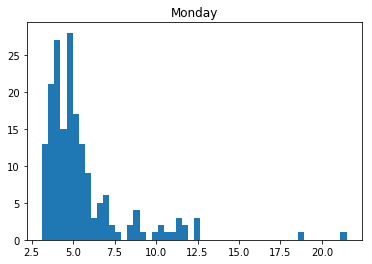

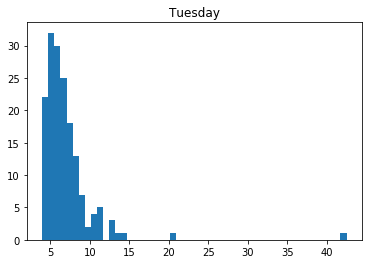

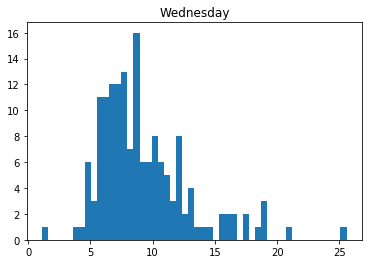

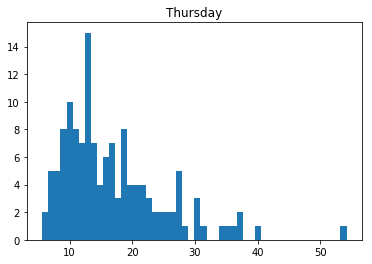

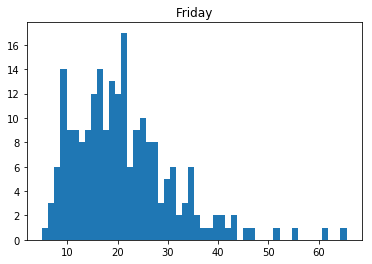

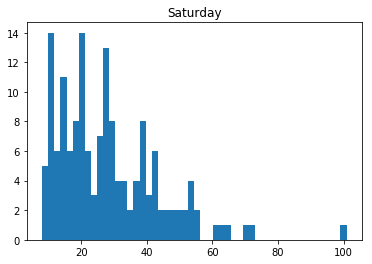

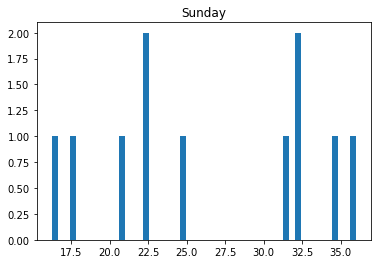

In [4]:
# identify outliers
for w in stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique():
    stats.loc[((stats['Weekday']==w)&(stats['Completed']==True)),'Minutes Spent Solving'].hist(grid=False,bins=50)
    plt.title(w)
    plt.show()

# From inspecting my own plots, I see:
# 1 clear outlier where solve time < 2 min
# clear outliers where solve time > 100 min

In [5]:
# remove outliers
print('%s records in raw data'%stats.shape[0])
stats = stats.loc[((stats['Minutes Spent Solving']<100)&
                   ((stats['Completed']==False)|
                    (stats['Minutes Spent Solving']>2)
                   )
                  )
                 ]
print('%s records without outliers'%stats.shape[0])

1203 records in raw data
1191 records without outliers


## Part 2: Basic Plots by Weekday

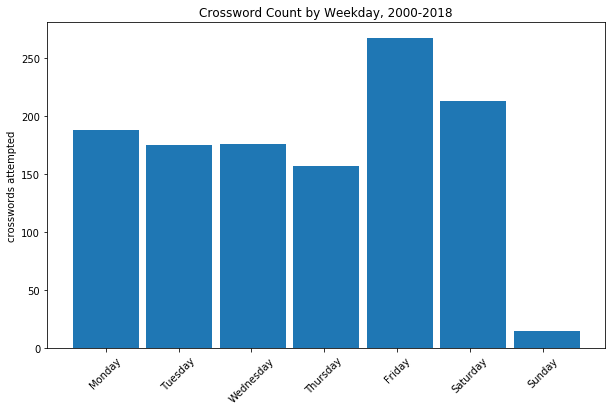

In [6]:
# Histogram of weekdays
ax = stats['Weekday (Numeric)'].hist(figsize=(10,6),bins=7,grid=False,xrot=45,align='left',rwidth=0.9)
ax.set_xticks([i*0.85 for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Crossword Count by Weekday, 2000-2018')
plt.ylabel('crosswords attempted')
plt.show()

In [7]:
# a bigger groupby for weekdays
weekday_stats = stats.groupby(by=['Weekday (Numeric)','Completed']).agg({ 'Completed' : ['count'],
                                                                          'Minutes Spent Solving' : ['mean','min']
                                                                        })
weekday_stats

Completed Minutes Spent Solving           
                                count                  mean        min
Weekday (Numeric) Completed                                           
0                 False             6              4.563889   0.633333
                  True            182              5.540934   3.133333
1                 False            10              9.966667   1.750000
                  True            165              7.015152   3.983333
2                 False            18              8.252778   0.500000
                  True            158              9.295675   3.983333
3                 False            22             25.464394   8.283333
                  True            135             16.909630   5.633333
4                 False            48             22.031250   1.766667
                  True            219             21.225342   5.016667
5                 False            60             22.433611   1.250000
                  True            153             27.677233   8.033333
6                 False             4             38.770833   0.150000
                  True             11             26.440909  16.250000

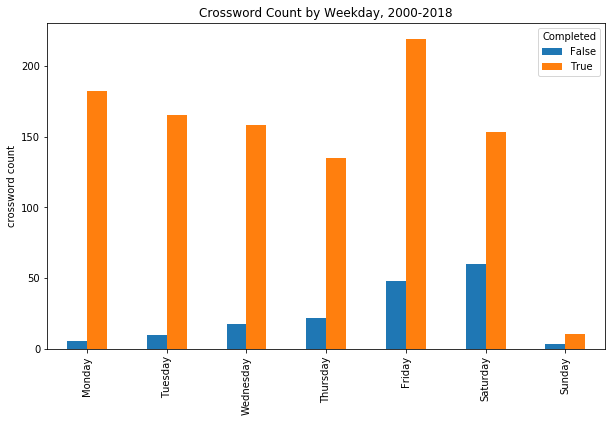

In [8]:
ax = weekday_stats.unstack()['Completed']['count'].plot.bar(figsize=(10,6),grid=False)
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Crossword Count by Weekday, 2000-2018')
plt.ylabel('crossword count')
plt.xlabel('')
plt.show()

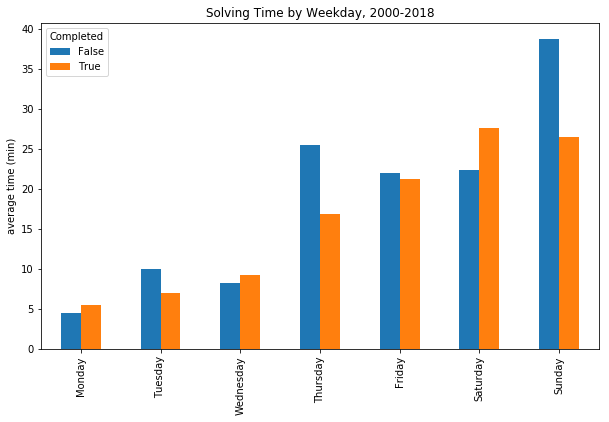

In [9]:
ax = weekday_stats.unstack()['Minutes Spent Solving']['mean'].plot.bar(figsize=(10,6),grid=False)
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Solving Time by Weekday, 2000-2018')
plt.ylabel('average time (min)')
plt.xlabel('')
plt.show()

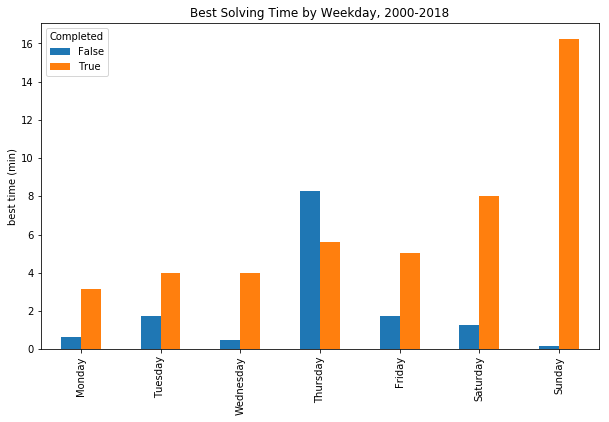

In [10]:
ax = weekday_stats.unstack()['Minutes Spent Solving']['min'].plot.bar(figsize=(10,6),grid=False)
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.title('Best Solving Time by Weekday, 2000-2018')
plt.ylabel('best time (min)')
plt.xlabel('')
plt.show()

## Part 3: When did I solve them?

In [11]:
stats['Weekday Opened (Numeric)'] = stats['First Opened'].apply(get_weekday)
stats['Weekday Opened'] = stats['First Opened'].apply(get_weekday, numeric=False)
stats['Relative Day Opened'] = stats['First Opened'].apply(datetime.date) - stats['Puzzle Date'].apply(datetime.date)
stats['Time of Day Opened'] = stats['First Opened'].apply(datetime.time)
stats['Hour of Day Opened'] = stats['Time of Day Opened'].apply(lambda x: x.hour)

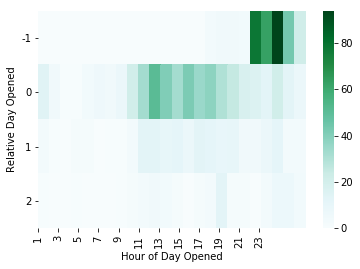

In [12]:
time_stats = stats.loc[stats['Relative Day Opened']<=timedelta(days=2)].groupby(by=['Relative Day Opened','Hour of Day Opened']).agg({'Completed':'count'})
ax = sns.heatmap(time_stats.unstack(fill_value = 0), cmap="BuGn")
ax.set_xticks([i*0.9 for i in range(24) if math.floor(i/2)*2==i])
ax.set_xticklabels([i+1 for i in range(24) if math.floor(i/2)*2==i])
ax.set_yticklabels([i-1 for i in range(9)])
plt.xlabel('Hour of Day Opened')
plt.show()

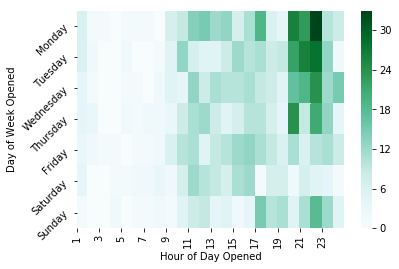

In [13]:
time_stats_abs = stats.groupby(by=['Weekday Opened (Numeric)','Hour of Day Opened']).agg({'Completed':'count'})
ax = sns.heatmap(time_stats_abs.unstack(fill_value = 0), cmap="BuGn")
ax.set_xticks([i for i in range(24) if math.floor(i/2)*2==i])
ax.set_xticklabels([i+1 for i in range(24) if math.floor(i/2)*2==i])
ax.set_yticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
for tick in ax.get_yticklabels():
    tick.set_rotation(45)
plt.xlabel('Hour of Day Opened')
plt.ylabel('Day of Week Opened')
plt.show()

## Basic Plots by Year & Month

In [14]:
stats['Puzzle Year'] = stats['Puzzle Date'].apply(lambda x: x.year)
stats['Puzzle Month'] = stats['Puzzle Date'].apply(lambda x: x.month)
stats['Year Opened'] = stats['First Opened'].apply(lambda x: x.year)
stats['Month Opened'] = stats['First Opened'].apply(lambda x: x.month)

In [15]:
yearly_stats = stats.groupby(by=['Puzzle Year','Completed']).agg({ 'Completed' : 'count',
                                                                   'Minutes Spent Solving' : ['mean','min']
                                                                 })
yearly_stats

Completed Minutes Spent Solving           
                          count                  mean        min
Puzzle Year Completed                                           
2005        False             1             11.033333  11.033333
            True              1             37.766667  37.766667
2007        True              1             34.250000  34.250000
2008        False             1             12.766667  12.766667
            True              1             13.333333  13.333333
2010        True              1             20.066667  20.066667
2011        False             2             58.516667  18.233333
            True              3             26.866667  25.183333
2012        False             3             11.761111   1.766667
            True              7             18.552381  10.700000
2013        False             6             16.888889  11.233333
            True             22             23.212121   9.216667
2014        False            21             24.050000   0.500000
            True             59             17.959040   3.566667
2015        False            47             27.636525   5.133333
            True            238             16.225350   3.316667
2016        False            12             16.377778   0.983333
            True            288             15.539583   3.233333
2017        False            39             16.459402   2.866667
            True            253             12.123057   3.133333
2018        False            36             13.181944   0.150000
            True            149             12.087136   3.433333

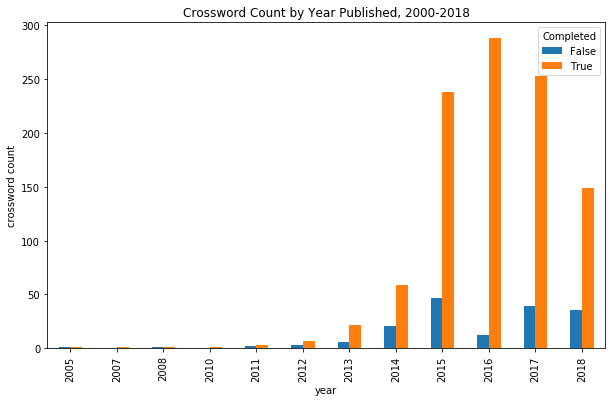

In [16]:
# total attempted and completed by puzzle year
ax = yearly_stats.unstack()['Completed']['count'].plot.bar(figsize=(10,6),grid=False)
ax.set_xticks([i for i in range(12)])
ax.set_xticklabels(stats.sort_values(by='Puzzle Year')['Puzzle Year'].unique())
plt.title('Crossword Count by Year Published, 2000-2018')
plt.ylabel('crossword count')
plt.xlabel('year')
plt.show()

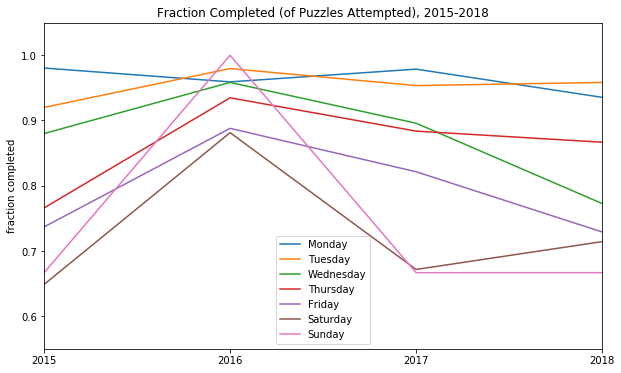

In [17]:
# percent completed by year & weekday
ax = stats.groupby(by=['Year Opened','Weekday (Numeric)']) \
          .agg({ 'Completed' : 'mean'}) \
          .unstack() \
          .plot.line(figsize=(10,6),grid=False)
plt.title('Fraction Completed (of Puzzles Attempted), 2015-2018')
ax.set_xticks(stats.sort_values(by='Year Opened')['Year Opened'].unique())
ax.set_xticklabels(stats.sort_values(by='Year Opened')['Year Opened'].unique())
plt.xlim([2015,2018])
plt.ylim([0.55,1.05])
plt.ylabel('fraction completed')
plt.xlabel('')
plt.legend(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.show()

In [18]:
yearly_weekday_stats = stats.loc[stats['Completed']==True] \
                            .groupby(by=['Puzzle Year','Weekday (Numeric)']).agg({ 'Completed' : 'count',
                                                                                   'Minutes Spent Solving' : ['mean','min']
                                                                                 })
yearly_weekday_stats.unstack(fill_value=0)['Completed']['count']

Weekday (Numeric),0,1,2,3,4,5,6
Puzzle Year,,,,,,,
2005,0,0,0,0,0,1,0
2007,0,0,0,0,0,1,0
2008,0,0,0,1,0,0,0
2010,0,0,0,0,1,0,0
2011,0,0,0,0,3,0,0
2012,0,0,0,0,7,0,0
2013,0,0,0,0,20,2,0
2014,11,7,8,5,22,6,0
2015,50,47,44,36,33,26,2


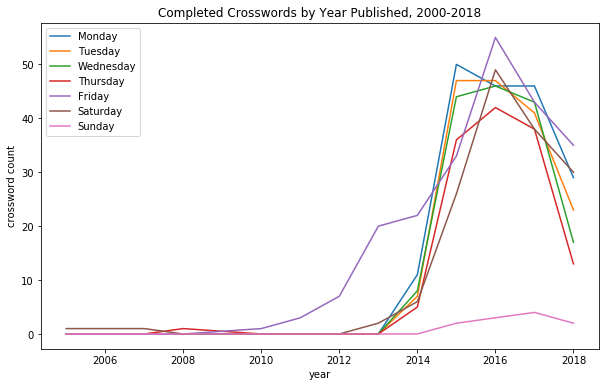

In [19]:
# total completed by weekday and year
ax = yearly_weekday_stats.unstack(fill_value=0)['Completed']['count'].plot.line(figsize=(10,6),grid=False)
plt.title('Completed Crosswords by Year Published, 2000-2018')
# ax.set_xticks(stats.sort_values(by='Puzzle Year')['Puzzle Year'].unique())
# ax.set_xticklabels(stats.sort_values(by='Puzzle Year')['Puzzle Year'].unique())
plt.ylabel('crossword count')
plt.xlabel('year')
plt.legend(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.show()

In [20]:
yearly_weekday_stats_op = stats.loc[stats['Completed']==True] \
                            .groupby(by=['Year Opened','Weekday (Numeric)']).agg({ 'Completed' : 'count',
                                                                                   'Minutes Spent Solving' : ['mean','min']
                                                                                 })
yearly_weekday_stats_op.unstack(fill_value=0)['Completed']['count']

Weekday (Numeric),0,1,2,3,4,5,6
Year Opened,,,,,,,
2014,10,7,8,5,7,2,0
2015,50,46,44,36,28,24,2
2016,47,48,46,43,103,52,3
2017,46,41,43,38,46,45,4
2018,29,23,17,13,35,30,2


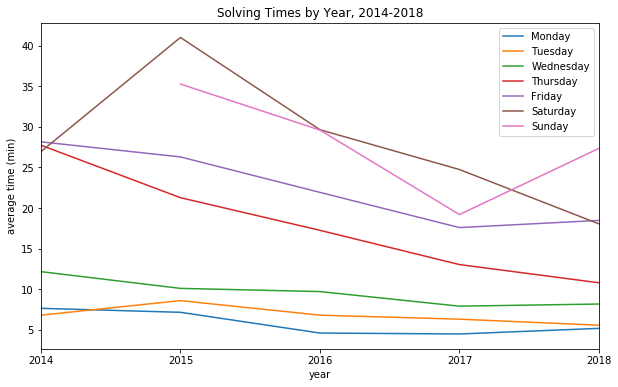

In [21]:
# average time by weekday and year
ax = yearly_weekday_stats_op.unstack()['Minutes Spent Solving']['mean'].plot.line(figsize=(10,6),grid=False)
plt.title('Solving Times by Year, 2014-2018')
ax.set_xticks(stats.sort_values(by='Year Opened')['Year Opened'].unique())
plt.xlim([2014,2018])
ax.set_xticklabels(stats.sort_values(by='Year Opened')['Year Opened'].unique())
plt.ylabel('average time (min)')
plt.xlabel('year')
plt.legend(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.show()

In [22]:
# average time, timeseries per weekday


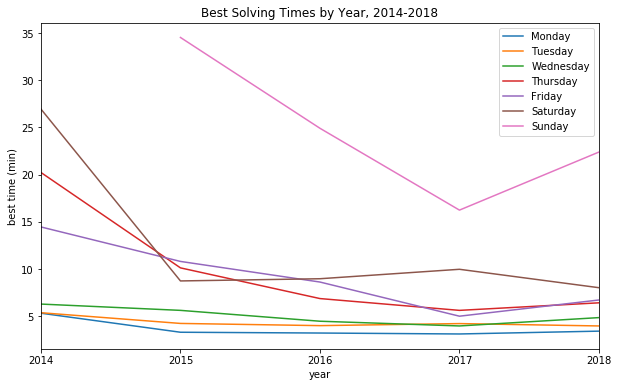

In [23]:
# minimum time by weekday and year
ax = yearly_weekday_stats_op.unstack()['Minutes Spent Solving']['min'].plot.line(figsize=(10,6),grid=False)
plt.title('Best Solving Times by Year, 2014-2018')
ax.set_xticks(stats.sort_values(by='Year Opened')['Year Opened'].unique())
plt.xlim([2014,2018])
ax.set_xticklabels(stats.sort_values(by='Year Opened')['Year Opened'].unique())
plt.ylabel('best time (min)')
plt.xlabel('year')
plt.legend(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.show()

In [24]:
# minimum time, timeseries per weekday

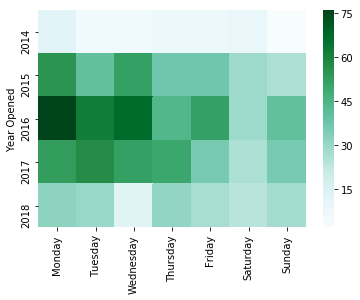

In [25]:
# crosswords completed by day opened, heat map over years (overweek shape)
open_time_stats = stats.sort_values(by='Weekday Opened (Numeric)').groupby(by=['Year Opened','Weekday Opened (Numeric)']).agg({ 'Completed' : 'count'})
ax = sns.heatmap(open_time_stats.unstack(), cmap="BuGn")
plt.xlabel('')
ax.set_xticklabels(stats.sort_values(by='Weekday Opened (Numeric)')['Weekday Opened'].unique())
plt.show()

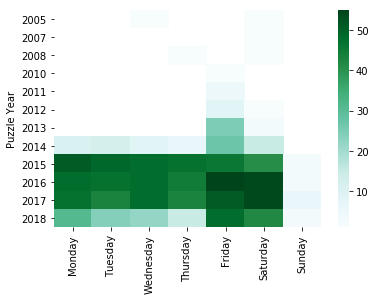

In [26]:
# crosswords completed by puzzle weekday, heat map over puzzle years (overweek shape)
puzzle_time_stats = stats.sort_values(by='Weekday (Numeric)').groupby(by=['Puzzle Year','Weekday (Numeric)']).agg({ 'Completed' : 'count'})
ax = sns.heatmap(puzzle_time_stats.unstack(), cmap="BuGn")
plt.ylim([12,0])
plt.xlabel('')
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.show()

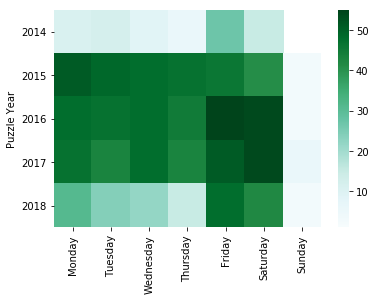

In [27]:
# crosswords completed each week, heat map over puzzle years (overweek shape)
open_time_stats = stats.sort_values(by='Weekday (Numeric)').groupby(by=['Puzzle Year','Weekday (Numeric)']).agg({ 'Completed' : 'count'})
ax = sns.heatmap(open_time_stats.unstack(), cmap="BuGn")
plt.ylim([12,7])
plt.xlabel('')
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.show()

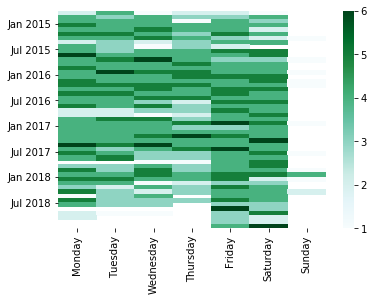

In [28]:
# crosswords completed by puzzle month and year (overall and for each weekday)
monthly_stats = stats.sort_values(by='Weekday (Numeric)').groupby(by=['Puzzle Year','Puzzle Month','Weekday (Numeric)']).agg({ 'Completed' : 'count'})
ax = sns.heatmap(monthly_stats.unstack().iloc[28:], 
                 cmap="BuGn")
ax.set_yticks([i*6+3 for i in range(8)])
ax.set_yticklabels([i for s in [['Jan ' + str(y), 'Jul ' + str(y)] for y in range(2015,2019)] for i in s])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.xlabel('')
plt.ylabel('')
plt.show()

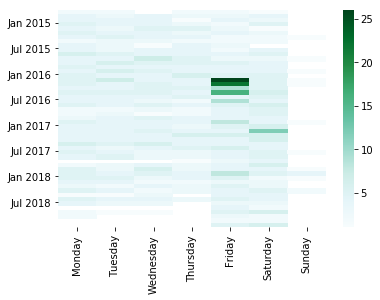

In [29]:
# crosswords completed by month and year opened (overall and for each weekday)
monthly_stats = stats.sort_values(by='Weekday (Numeric)').groupby(by=['Year Opened','Month Opened','Weekday (Numeric)']).agg({ 'Completed' : 'count'})
ax = sns.heatmap(monthly_stats.unstack(),#.iloc[28:], 
                 cmap="BuGn")
ax.set_yticks([i*6+3 for i in range(8)])
ax.set_yticklabels([i for s in [['Jan ' + str(y), 'Jul ' + str(y)] for y in range(2015,2019)] for i in s])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.xlabel('')
plt.ylabel('')
plt.show()

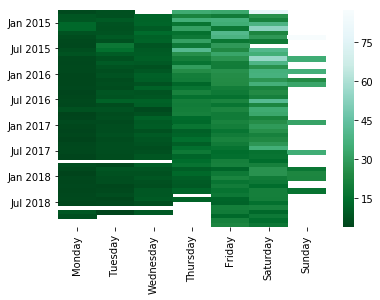

In [30]:
# average time by month and year (overall and for each weekday)
solve_time_stats = stats.sort_values(by='Weekday (Numeric)').groupby(by=['Year Opened','Month Opened','Weekday (Numeric)']).agg({ 'Minutes Spent Solving' : 'mean'})
ax = sns.heatmap(solve_time_stats.unstack(),#.iloc[28:], 
                 cmap="BuGn_r")
ax.set_yticks([i*6+3 for i in range(8)])
ax.set_yticklabels([i for s in [['Jan ' + str(y), 'Jul ' + str(y)] for y in range(2015,2019)] for i in s])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.xlabel('')
plt.ylabel('')
plt.show()

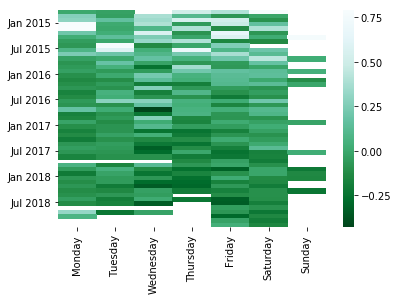

In [31]:
df_norm = lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))
ax = sns.heatmap(solve_time_stats.unstack().apply(df_norm), cmap="BuGn_r")
ax.set_yticks([i*6+3 for i in range(8)])
ax.set_yticklabels([i for s in [['Jan ' + str(y), 'Jul ' + str(y)] for y in range(2015,2019)] for i in s])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.xlabel('')
plt.ylabel('')
plt.show()

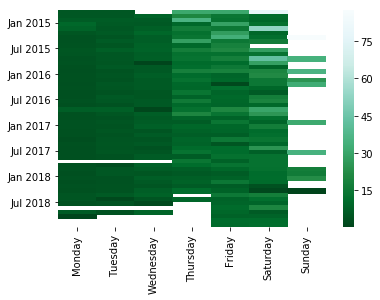

In [32]:
# min time by month and year (overall and for each weekday)
min_time_stats = stats.sort_values(by='Weekday (Numeric)').groupby(by=['Year Opened','Month Opened','Weekday (Numeric)']).agg({ 'Minutes Spent Solving' : 'min'})
ax = sns.heatmap(min_time_stats.unstack(),
                 cmap="BuGn_r")
ax.set_yticks([i*6+3 for i in range(8)])
ax.set_yticklabels([i for s in [['Jan ' + str(y), 'Jul ' + str(y)] for y in range(2015,2019)] for i in s])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.xlabel('')
plt.ylabel('')
plt.show()

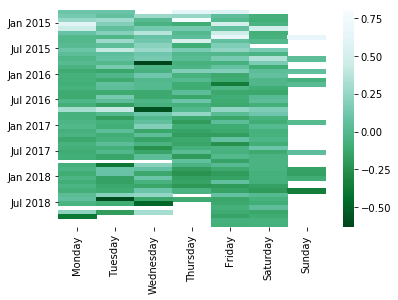

In [33]:
ax = sns.heatmap(min_time_stats.unstack().apply(df_norm), cmap="BuGn_r")
ax.set_yticks([i*6+3 for i in range(8)])
ax.set_yticklabels([i for s in [['Jan ' + str(y), 'Jul ' + str(y)] for y in range(2015,2019)] for i in s])
ax.set_xticklabels(stats.sort_values(by='Weekday (Numeric)')['Weekday'].unique())
plt.xlabel('')
plt.ylabel('')
plt.show()

/Users/kimberly.schlesinger/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


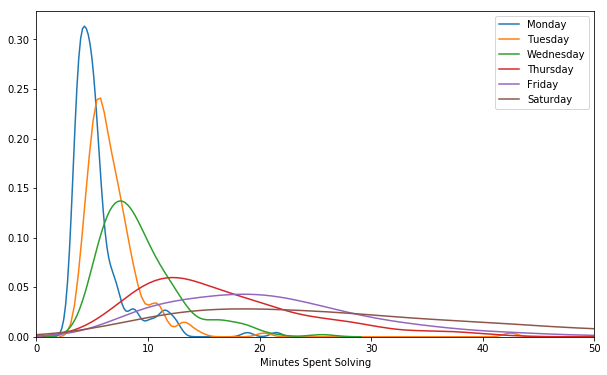

In [34]:
plt.figure(figsize=(10,6))
for w in stats.loc[stats['Weekday']!='Sunday'].sort_values(by='Weekday (Numeric)')['Weekday'].unique():
    mins = stats.loc[((stats['Weekday']==w)&(stats['Completed']==True)),'Minutes Spent Solving']
    sns.distplot(mins, label=w, hist=False)
plt.xlim([0,50])    
plt.legend()
plt.show()